<a href="https://colab.research.google.com/github/zfukuoka/Copying_a_sutra/blob/master/ISBN978-4-7981-6720-6/list9_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 9 変分オートエンコーダ（VAE）

* 9.4 VAEの実装

### リスト 9.6 訓練用データの用意

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


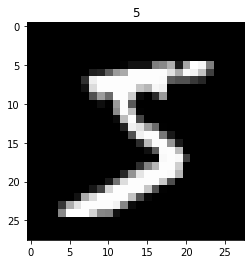

訓練用データの形状: (60000, 784) テスト用データの形状: (10000, 784)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()
print(x_train.shape, x_test.shape)

# 書くピクセルの値を0-1の範囲に収める
x_train = x_train / 255
x_test = x_test / 255

# 手書き文字画像を1つ表示
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show()

# 1次元に変換する
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("訓練用データの形状:", x_train.shape, "テスト用データの形状:", x_test.shape)

#### リスト 9.7 VAEの各設定

In [2]:
epochs = 10
batch_size = 128
n_in_out = 784
n_z = 2
n_mid = 256

### リスト 9.8 VAEのモデル構築

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K

# 潜在変数をサンプリングするための関数
def z_sample(args):
  mu, log_var = args
  epsilon = K.random_normal(shape=K.shape(log_var), mean=0, stddev=1)
  return mu + epsilon * K.exp(log_var / 2)

# Encoder
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

# Decoder
mid_decoder = Dense(n_mid, activation="relu")
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")
y = out_decoder(h_decoder)

# VAEのモデルを生成
model_vae = Model(x, y)

# 損失関数
eps = 1e-7
rec_loss = K.sum(-x * K.log(y + eps) - (1 - x) * K.log(1 - y + eps)) / batch_size
reg_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size
vae_loss = rec_loss + reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            514         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            514         ['dense[0][0]']                  
                                                                                              

### リスト 9.9 VAEの学習

In [4]:
model_vae.fit(
    x_train, x_train, shuffle=True, epochs=epochs,
    batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 11s 21ms/step - loss: 204.0578 - val_loss: 174.9678
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 173.2596 - val_loss: 167.6692
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 168.8146 - val_loss: 164.7344
Epoch 4/10
469/469 [==============================] - 9s 18ms/step - loss: 165.9658 - val_loss: 162.3846
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 163.6723 - val_loss: 160.7265
Epoch 6/10
469/469 [==============================] - 10s 20ms/step - loss: 162.0300 - val_loss: 159.5000
Epoch 7/10
469/469 [==============================] - 10s 21ms/step - loss: 160.7360 - val_loss: 158.5326
Epoch 8/10
469/469 [==============================] - 10s 22ms/step - loss: 159.7008 - val_loss: 157.6150
Epoch 9/10
469/469 [==============================] - 9s 20ms/step - loss: 158.8174 - val_loss: 156.9128
Epoch 10/10
469/469 [=============================